In [21]:
import torch
import pytorch_lightning as pl
from models.pi_nets import CCP, CCP_relu, CCP_relu_poly, PDC, PDCLow
from models.neural_nets import FeedForwardNN, PolynomialNN, PolynomialNN_relu
from data.polynomials import NormalGenerator
from data.simulation_functions import ShortColumn, SteelColumn, SulfurModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import torch.distributions as dist
from utils import model_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch.distributions as dist
dist.log_normal.LogNormal(np.log(71.0), np.log(1.15)).sample()

tensor(62.0686)

In [23]:
#data_gen = ShortColumn(100000)
#data_gen = NormalGenerator(lambda a: 1/a, 1, 100000)
data_gen = SulfurModel(100000)
feature_samples, target_samples = data_gen.generate_train_data()
target_samples.quantile(torch.tensor([0, 0.25, 0.5, 0.75, 1]))

tensor([-8.6301e-08, -5.3813e-08, -2.0820e-08, -5.9973e-09, -4.6991e-10])

In [25]:
target_samples[:5]

tensor([-2.4531e-09, -3.2263e-09, -5.3240e-08, -8.8454e-09, -7.1272e-08])

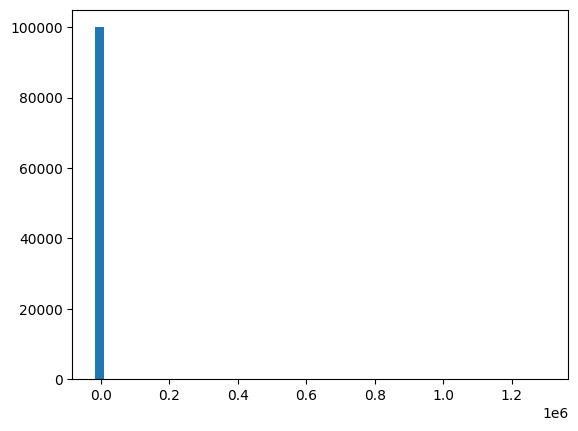

In [6]:
plt.hist(target_samples, bins=50);

# Model Performance

In [4]:
checkpoint = r"tb_logs\2a2_b2_c2-3d\CCP\version_0\checkpoints\epoch=49-step=3200.ckpt"
model = CCP.load_from_checkpoint(checkpoint)
print(model_utils.count_parameters(model))

1985


In [28]:
polynomial = lambda a, b, c, d, e: (a**3)*(b**3)*(c**3) - d**4*e**4
n_features = polynomial.__code__.co_argcount
data_gen = NormalGenerator(polynomial, n_features, 50000, 90, 1)
feature_samples, target_samples = data_gen.generate_train_data()

In [29]:
target_samples.quantile(torch.tensor([0, 0.25, 0.5, 0.75, 1]))

tensor([2.9665e+17, 3.6829e+17, 3.8313e+17, 3.9842e+17, 4.8776e+17])

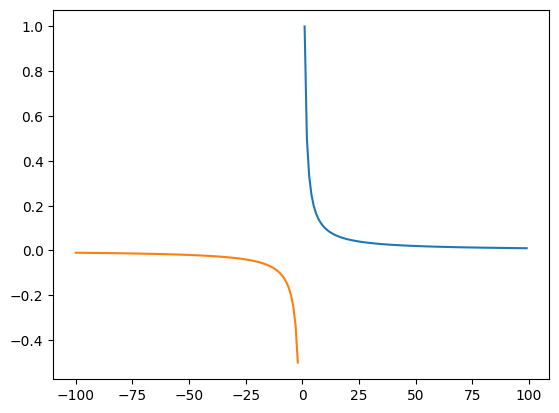

In [4]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1,100)
x2 = np.arange(-100, -1)
y = 1/x
y2 = 1/x2
plt.plot(x,y)
plt.plot(x2, y2)

In [19]:
scales = range(90, 100)
means = range(0, 5)
plot_dict = {'mu': [],
             'sigma': [],
             'r2': []}
for mu in means:
    for sigma in scales:
        plot_dict['mu'].append(mu)
        plot_dict['sigma'].append(sigma)
        distribution = dist.normal.Normal(mu, sigma)
        x = distribution.sample((25000,n_features))
        y = polynomial(*x.clone().permute(1,0))
        with torch.no_grad():
            y_hat = model(x)
            plot_dict['r2'].append(r2_score(y, y_hat))
            
df = pd.DataFrame(plot_dict)
data = df.pivot(index="mu", columns="sigma", values="r2")

In [20]:
data

sigma,90,91,92,93,94,95,96,97,98,99
mu,,,,,,,,,,
0,0.895252,0.899789,0.889713,0.896449,0.890145,0.888073,0.899572,0.892204,0.885890,0.902485
1,0.890843,0.903883,0.888790,0.885230,0.897573,0.882052,0.890398,0.905205,0.897598,0.859865
2,0.881039,0.889944,0.886296,0.897580,0.886569,0.895351,0.872168,0.890316,0.899445,0.893754
3,0.898813,0.884452,0.876099,0.888344,0.898314,0.903576,0.897698,0.887526,0.907487,0.883034
4,0.885316,0.898354,0.884837,0.900744,0.882773,0.900480,0.882430,0.893235,0.882878,0.885646


c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


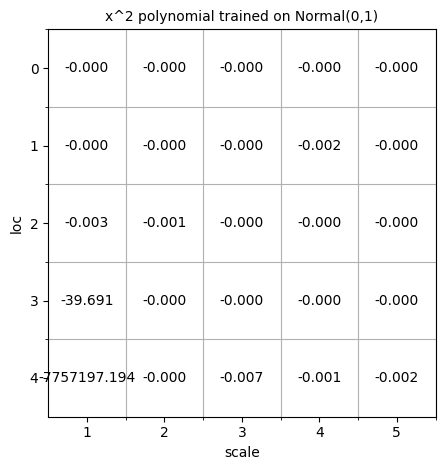

In [8]:
loc = 0
scale = 1
fig, ax = plt.subplots()
ax.set_title("x^2 polynomial trained on Normal(0,1)", fontsize=10)
ax.grid(True, which="minor")
ax.imshow(data, alpha=0)

ax.set_ylabel("loc")
ax.set_xlabel("scale")
ax.set_xticks(np.array(scales)-0.5, minor=True)
ax.set_yticks(np.array(means)-0.5, minor=True)
ax.set_yticklabels([''] + data.index.values.tolist())
ax.set_xticklabels([''] + data.columns.values.tolist())

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.3f}'.format(z), ha="center", va="center")

#fig.suptitle("PolyNN R2 for shifting distributions");
fig.tight_layout()
#fig.savefig("imgs/PolyNN_x2_test.png", dpi=600, transparent=True)

R2: -0.0005516316404605703


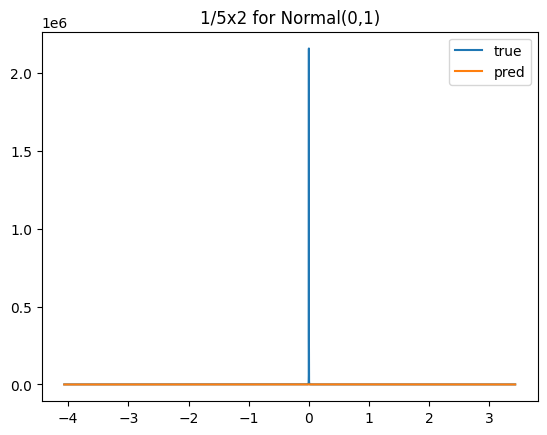

In [17]:
dist = Normal(0, 1)
x = dist.sample((10000,1))
y = x.clone().apply_(polynomial)

with torch.no_grad():
    y_hat = model(x)
    print("R2:", r2_score(y, y_hat))

indices = torch.argsort(x, dim=0).squeeze()
plt.plot(x[indices], y[indices], label="true")
plt.plot(x[indices], y_hat[indices], label="pred")
plt.legend()
plt.title("1/5x2 for Normal(0,1)");

R2: -152870.5153965726


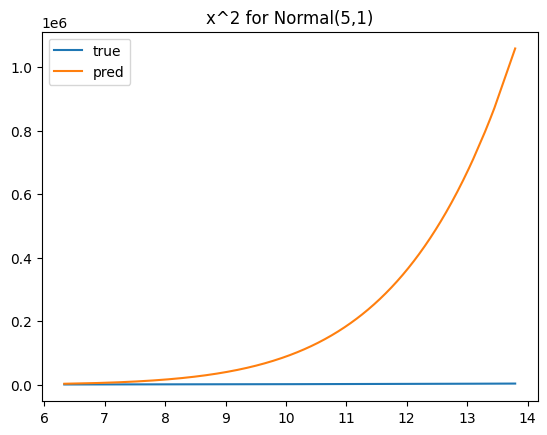

In [51]:
dist = Normal(10, 1)
x = dist.sample((10000,1))
y = x.clone().apply_(polynomial)

with torch.no_grad():
    y_hat = model(x)
    print("R2:", r2_score(y, y_hat))

indices = torch.argsort(x, dim=0).squeeze()
plt.plot(x[indices], y[indices], label="true")
plt.plot(x[indices], y_hat[indices], label="pred")
plt.legend()
plt.title("x^2 for Normal(5,1)");

In [ ]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="feedfoward_x2")
trainer = pl.Trainer(limit_train_batches=64,max_epochs=30, log_every_n_steps=25, logger=logger)
trainer.test(model, dataloaders=dataloader)